This notebook is part of the ``deepcell-tf`` documentation: https://deepcell.readthedocs.io/.

# Mesmer segmentation

In [1]:
# Download multiplex data
from deepcell.datasets import multiplex_tissue
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

51920896/51905517 [==============================] - 1s 0us/step


In [2]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(X_train, channel_colors=['green', 'blue'])

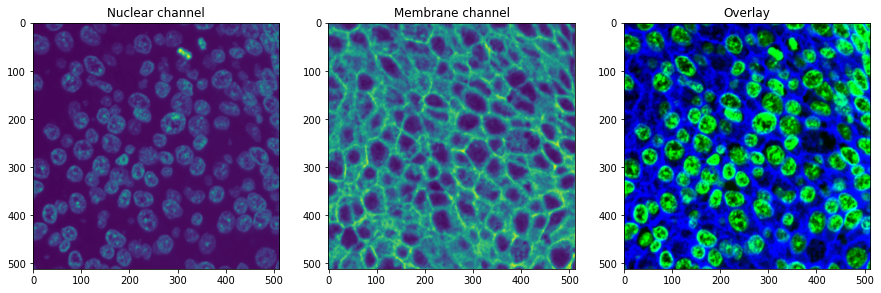

In [3]:
from matplotlib import pyplot as plt

# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(X_train[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

## Whole Cell Segmentation

### Initialize Mesmer model

The application will download pretrained weights for tissue segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [4]:
from deepcell.applications import Mesmer
app = Mesmer()

96894976/96885295 [==============================] - 1s 0us/step


2022-06-10 16:21:20.187152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-06-10 16:21:20.187205: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 16:21:20.187253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-06-10 16:21:20.187540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [5]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [6]:
segmentation_predictions = app.predict(X_train, image_mpp=0.5)

In [7]:
# create overlay of predictions
from deepcell.utils.plot_utils import make_outline_overlay
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)

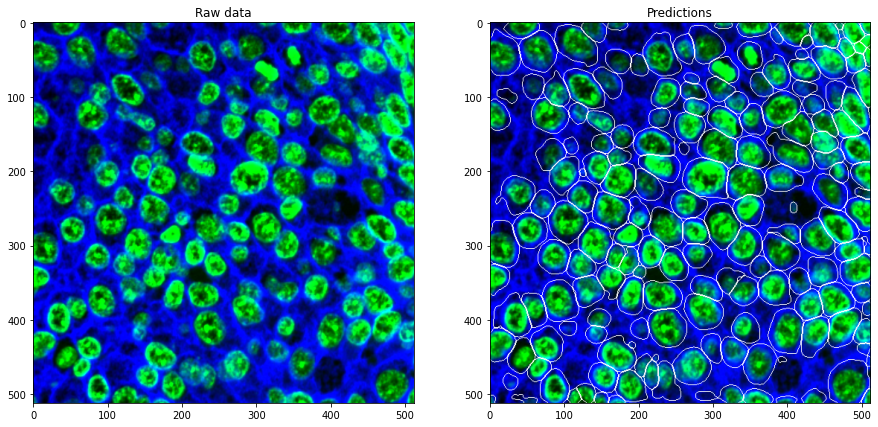

In [8]:
# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

## Nuclear Cell Segmentation

In addition to predicting whole-cell segmentation, Mesmer can also be used for nuclear predictions

In [9]:
segmentation_predictions_nuc = app.predict(X_train, image_mpp=0.5, compartment='nuclear')

In [10]:
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_nuc)

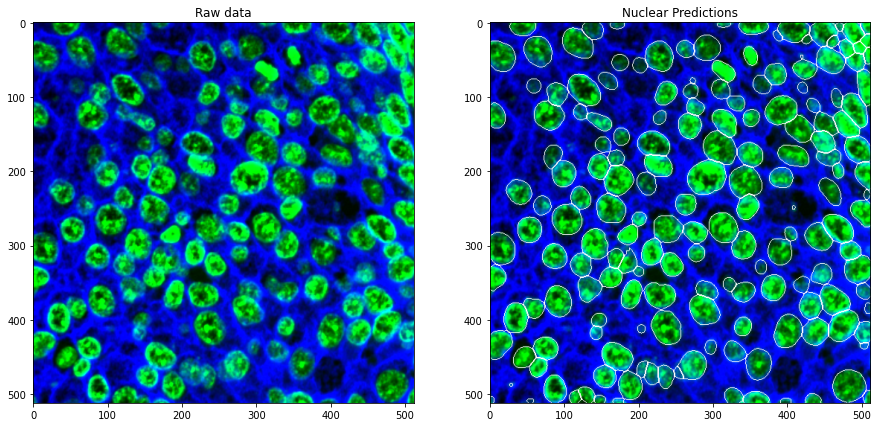

In [11]:
# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data_nuc[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Nuclear Predictions')
plt.show()

## Fine-tuning the model output

In most cases, we find that the default settings for the model work quite well across a range of tissues. However, if you notice specific, consistent errors in your data, there are a few things you can change.

The first is the `interior_threshold` parameter. This controls how conservative the model is in estimating what is a cell vs what is background. Lower values of `interior_threshold` will result in larger cells, whereas higher values will result in smaller smalls. 

The second is the `maxima_threshold` parameter. This controls what the model considers a unique cell. Lower values will result in more separate cells being predicted, whereas higher values will result in fewer cells. 

In [12]:
# To demonstrate the effect of `interior_threshold`, we'll compare the default  with a much more stringent setting
segmentation_predictions_interior = app.predict(X_train, image_mpp=0.5, 
                                               postprocess_kwargs_whole_cell={'interior_threshold': 0.5})
overlay_data_interior = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_interior)


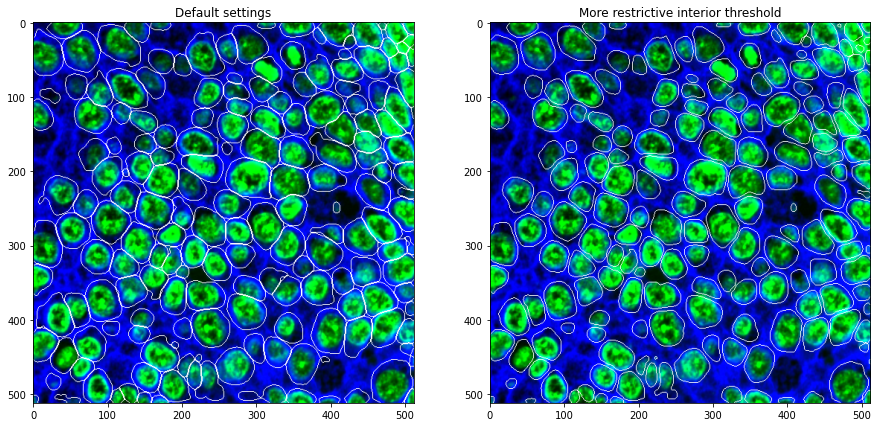

In [13]:
# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(overlay_data[idx, ...])
ax[1].imshow(overlay_data_interior[idx, ...])
ax[0].set_title('Default settings')
ax[1].set_title('More restrictive interior threshold')
plt.show()

In [14]:
# To demonstrate the effect of `maxima_threshold`, we'll compare the default with a much more stringent setting
segmentation_predictions_maxima = app.predict(X_train, image_mpp=0.5, 
                                               postprocess_kwargs_whole_cell={'maxima_threshold': 0.8})
overlay_data_maxima = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_maxima)


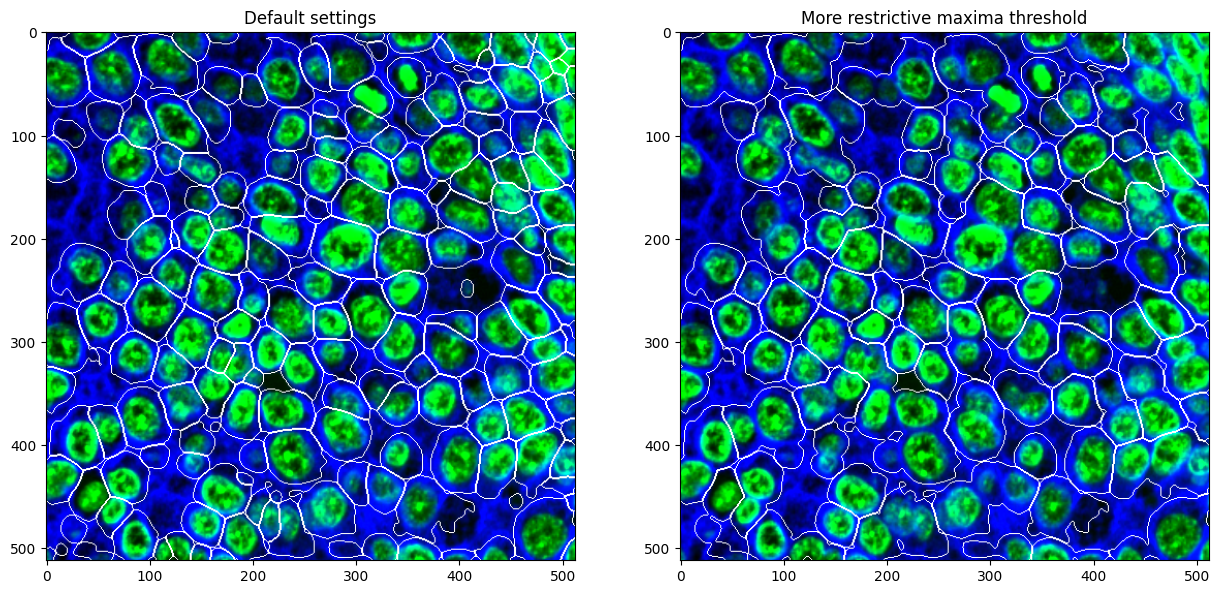

In [15]:
# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(overlay_data[idx, ...])
ax[1].imshow(overlay_data_maxima[idx, ...])
ax[0].set_title('Default settings')
ax[1].set_title('More restrictive maxima threshold')
plt.show()

Finally, if your data doesn't include in a strong membrane marker, the model will default to just predicting the nuclear segmentation, even for whole-cell mode. If you'd like to add a manual pixel expansion after segmentation, you can do that using the `pixel_expansion` argument. This will universally apply an expansion after segmentation to each cell

In [16]:
# To demonstrate the effect of `pixel_expansion`, we'll compare the nuclear output with expanded output
segmentation_predictions_expansion = app.predict(X_train, image_mpp=0.5, compartment='nuclear',
                                               postprocess_kwargs_nuclear={'pixel_expansion': 5})
overlay_data_expansion = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_expansion)


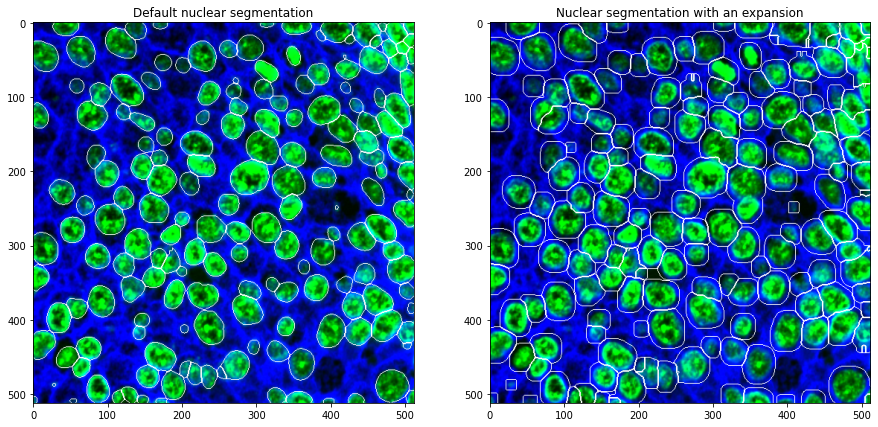

In [17]:
# select index for displaying
idx = 3

# plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(overlay_data_nuc[idx, ...])
ax[1].imshow(overlay_data_expansion[idx, ...])
ax[0].set_title('Default nuclear segmentation')
ax[1].set_title('Nuclear segmentation with an expansion')
plt.show()

There's a separate dictionary passed to the model that controls the post-processing for whole-cell and nuclear predictions. You can modify them independently to fine-tune the output. The current defaults the model is using can be found here: https://github.com/vanvalenlab/deepcell-tf/blob/master/deepcell/applications/mesmer.py#L272